In [1]:
import warnings
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from mpvn.data.grad.lit_data_module import LightningGradDataModule
from mpvn.metric import WordErrorRate, CharacterErrorRate
from mpvn.model import *

from mpvn.configs import DictConfig

/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: latest is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="valid_loss",
    mode="min",
    dirpath="checkpoint",
    filename="mpvn-{epoch:02d}-{valid_loss:.2f}-{valid_per:.2f}-{valid_acc}",
)
early_stop_callback = EarlyStopping(
    monitor="valid_loss", 
    min_delta=0.00, 
    patience=5, 
    verbose=False, 
    mode="min"
)
logger = TensorBoardLogger("tensorboard", name="Pronunciation for Vietnamese")

In [3]:
configs = DictConfig()

pl.seed_everything(configs.seed)
warnings.filterwarnings('ignore')

data_module = LightningGradDataModule(configs)
vocab = data_module.get_vocab() 

trainer = pl.Trainer(accelerator='cpu',
                      gpus=0,
                      logger=logger,
                      max_epochs=configs.max_epochs,
                      callbacks=[checkpoint_callback, early_stop_callback])

Global seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
model = ConformerRNNModel(
    configs=configs,
    num_classes=len(vocab),
    vocab=vocab,
    per_metric=WordErrorRate(vocab)
)

Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]['vivosdev09_297'] tensor([1, 1, 1, 0, 1])

Result of vivosdev09_297
EP: torch.Size([54]) e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5e5
PR: torch.Size([19]) iəiəiəəː6əː6u2ɔ5əː6iəaː6aː6əː6əː6ɔ5u2əː6əː6kaː6
Ro: torch.Size([19]) teɜ-naː2w-laː2-hwaː2n-haː4w<e>
Rc: torch.Size([19]) teɜ-naː2w-laː2-hwo4j-haː4w<e>
Per: 1.2666666666666666
MED output   : tensor([0, 0, 0, 0, 0])
Score        : tensor([1, 1, 1, 0, 1])
Accuracy: 0.2
Decoder-Encoder Attention: torch.Size([19, 54])


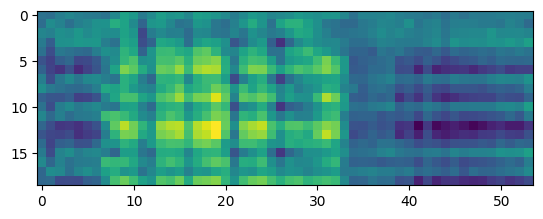

Validation DataLoader 0: 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]

2022-12-23 01:03:44.209616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 01:03:44.505034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 01:03:44.505071: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 01:03:44.541144: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-23 01:03:45.717219: W tensorflow/stream_executor/platform/de

Validation DataLoader 0: 100%|██████████| 50/50 [00:10<00:00,  4.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid_acc           0.5180441780441779
        valid_f1            0.6295722435608693
       valid_loss           1.9015270471572876
        valid_per           1.2922680377960205
     valid_precision        0.5169503274503273
      valid_recall          0.8726825396825398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid_loss': 1.9015270471572876,
  'valid_per': 1.2922680377960205,
  'valid_acc': 0.5180441780441779,
  'valid_f1': 0.6295722435608693,
  'valid_precision': 0.5169503274503273,
  'valid_recall': 0.8726825396825398}]

In [5]:
trainer.validate(model, data_module)

In [6]:
# model.df